In [1]:
import torch
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pickle
import yaml
import os
import cv2

In [2]:
task = ["openable", "cuttable", "pourable", "containable", "supportable", "holdable"]

In [3]:
cmap = mcolors.ListedColormap(['black', 'red', 'white'])
norm = mcolors.Normalize(0, 255)

def plot(input=None, weak_target=None, target=None, output=None, mask=None):
    if input is not None:
        plt.figure(figsize=(6, 6))
        plt.imshow(input)
        plt.title("Input", fontsize=20)
        plt.show()

    if weak_target is not None:
        plt.figure(figsize=(30, 4))
        num_classes = len(weak_target)
        for i in range(num_classes):
            plt.subplot(1, num_classes, i+1)
            img = np.array(weak_target[i])
            img[img==255] = 128
            img[img==1] = 255
            plt.imshow(img, cmap=cmap, norm=norm)
            plt.title("Weak: " + task[i], fontsize=20)
        plt.show()

    if target is not None:
        plt.figure(figsize=(30, 4))
        num_classes = len(target)
        for i in range(num_classes):
            plt.subplot(1, num_classes, i+1)
            img = np.array(target[i])
            img[img==255] = 128
            img[img==1] = 255
            plt.imshow(img, cmap=cmap, norm=norm)
            plt.title("Target: " + task[i], fontsize=20)
        plt.show()
    
    if output is not None:
        plt.figure(figsize=(30, 4))
        num_classes = len(output)
        for i in range(num_classes):
            plt.subplot(1, num_classes, i+1)
            img = np.array(output[i])
            img[img==1] = 255
            plt.imshow(img, cmap=cmap, norm=norm)
            plt.title("Output: " + task[i], fontsize=20)
        plt.show()

    if mask is not None:
        plt.figure(figsize=(6, 6))
        img = np.array(mask)
        img[img==1] = 255
        plt.imshow(img, cmap=cmap, norm=norm)
        plt.title("Mask", fontsize=20)
        plt.show()

In [4]:
def image_draw(image, keypoint):
    new_image = Image.fromarray(image.copy())
    draw = ImageDraw.Draw(new_image)
    stroke_width = 10
    for _, joints in keypoint:
        if len(joints) > 1:
            draw.line(np.array(joints).flatten(), 1, 10, joint="curve")
        for i in range(len(joints)):
            draw.ellipse(
                (
                    joints[i][0] - stroke_width / 2,
                    joints[i][1] - stroke_width / 2,
                    joints[i][0] + stroke_width / 2,
                    joints[i][1] + stroke_width / 2,
                ),
                1,
            )

    return new_image

In [ ]:
from model import CerberusAffordanceModel

model = CerberusAffordanceModel(len(task))

resume_time = "20220724_033524"
resume_level = "model_best" # model_best, checkpoint_latest
resume_path = f"output/{resume_time}/model/{resume_level}.pth"

model.load_state_dict(
    {
        k.replace("module.", ""): v
        for k, v in torch.load(resume_path)["state_dict"].items()
    }
)
model.eval()

print(task)

In [6]:
keypoint_path = "../dataset/cad120/object/train_affordance_keypoint.yaml"

with open(keypoint_path, "r") as fb:
    keypoint_dict = yaml.safe_load(fb)

In [5]:
import transform as TF

mean = [132.47758920907586, 106.32022472065732, 111.5704799224029]
std = [67.45043019809088, 70.23484330785524, 72.19806953380163]

tf = TF.Compose(
    [
        TF.ConvertPointLabel(
            stroke_width=40, ignore_index=255
        ),
        # TF.RandomScaledTiltedWarpedPIL(
        #     random_crop_size=(256, 256),
        #     random_scale_max=1.25,
        #     random_scale_min=0.8,
        #     random_tilt_max_deg=10,
        #     random_wiggle_max_ratio=0,
        #     random_horizon_reflect=True,
        #     center_offset_instead_of_random=False,
        #     ignore_index=255,
        # ),
        TF.PILToTensor(),
        TF.ImageNormalizeTensor(
            mean=mean, std=std
        ),
    ]
)


In [7]:
file_name = "10009_1"
input_path = f"../dataset/cad120/object/affordance/images/{file_name}.png"
target_path = f"../dataset/cad120/object/affordance/labels/{file_name}.pkl"
# weak_target_path = f"../dataset/cad120/object/train_affordance_weak_label/{file_name}.pkl"

data = dict()

data["file_name"] = os.path.basename(input_path).split(".")[0]

data["image"] = Image.open(input_path)

with open(target_path, "rb") as fb:
    dense_label = pickle.load(fb)
    data["dense_label"] = [Image.fromarray(dense_label[:, :, i]) for i in range(dense_label.shape[2])]

# with open(weak_target_path, "rb") as fb:
#     weak_label = pickle.load(fb)
#     data["weak_label"] = [Image.fromarray(weak_label[:, :, i]) for i in range(weak_label.shape[2])]

data["point_label"] = keypoint_dict[data["file_name"]]

data["validity"] = Image.new("L", data["image"].size, color=1)

In [8]:
print(data["point_label"])

[[0, [[122.38, 170.76]]], [1, []], [2, []], [3, []], [4, [[171.53, 96.031]]], [5, []]]


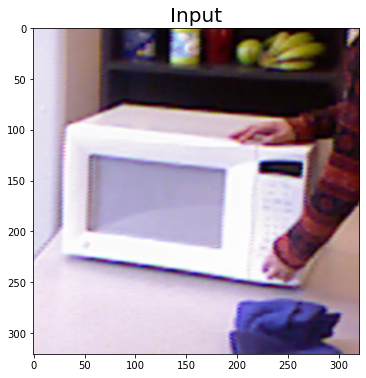

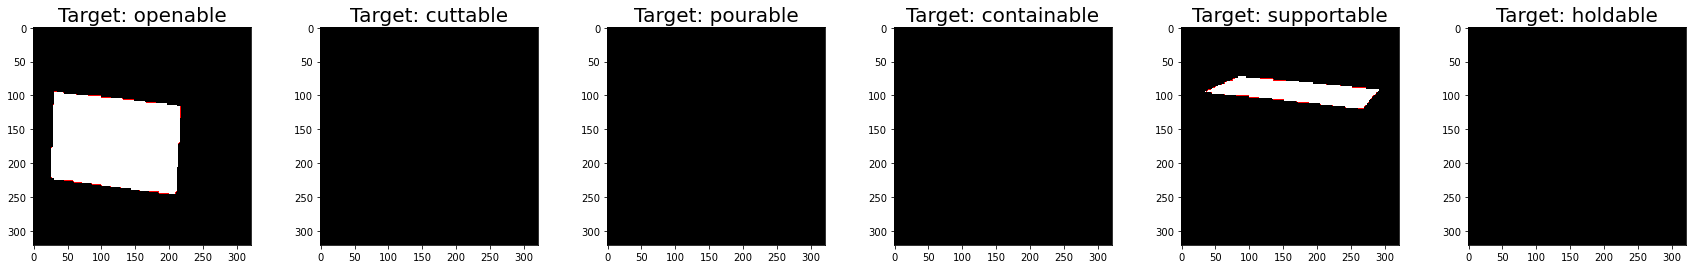

In [9]:
plot(input=data["image"], target=data["dense_label"], weak_target=data["weak_label"] if "weak_label" in data else None)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


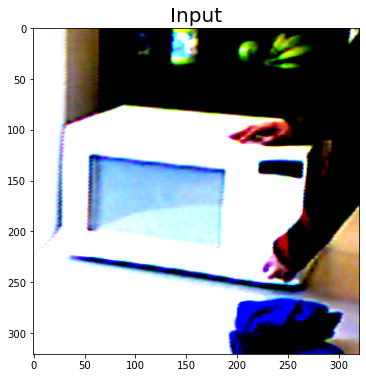

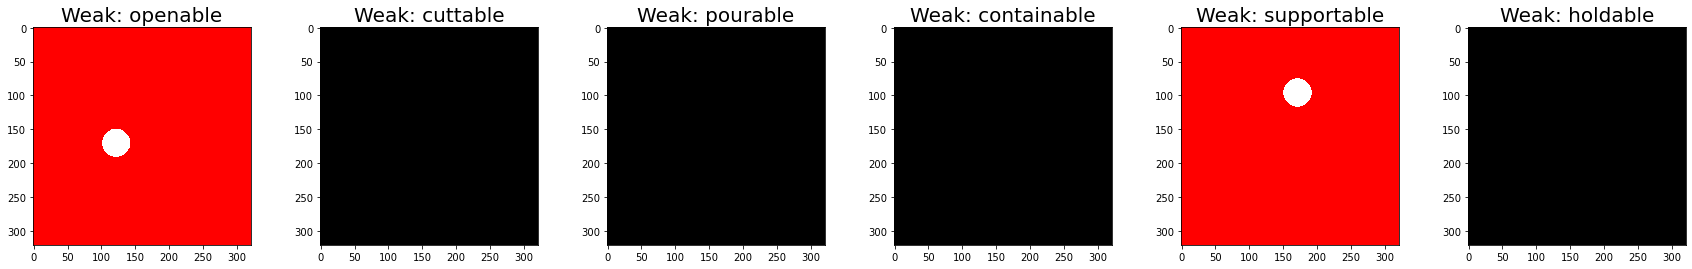

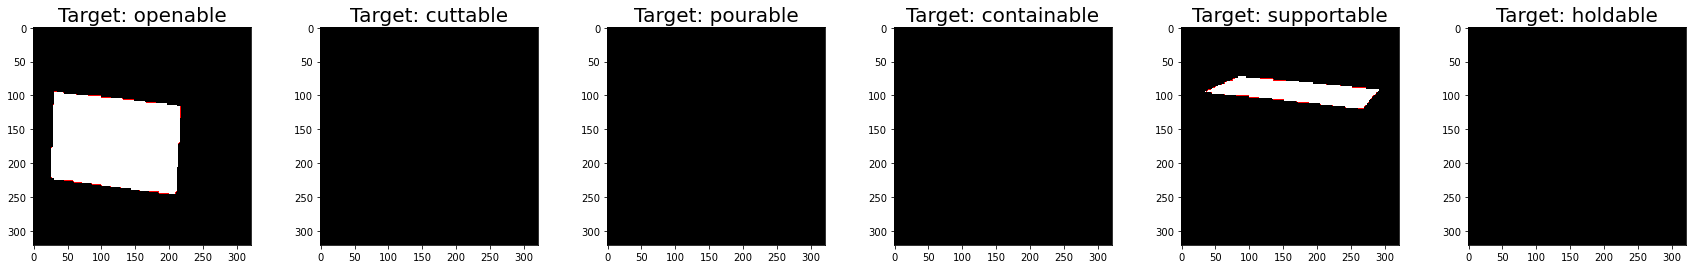

In [10]:
new_data = tf(data.copy())
image = new_data["image"].permute(1, 2, 0).contiguous().numpy()

plot(input=image, weak_target=new_data["weak_label"], target=new_data["dense_label"])

In [ ]:
with torch.no_grad():
    output = model(new_data["image"].unsqueeze(0))

In [ ]:
validity = new_data["validity"].squeeze(0)
pred = [output[i].argmax(1).squeeze(0) * validity for i in range(len(task))]
# pred = [(output[i].sigmoid().squeeze(0).squeeze(0) > 0.5).int() * validity for i in range(len(task))]

plot(weak_target=new_data["weak_label"], target=new_data["dense_label"], output=pred, mask=validity)

In [ ]:
image = np.array(data["image"])

pseudo_label = Image.new("L", (image.shape[1], image.shape[0]), color=cv2.GC_PR_BGD)
pseudo_draw = ImageDraw.Draw(pseudo_label)
for _, joints in data["point_label"]:
    if len(joints) > 0:
        for i in range(len(joints)):
            pseudo_draw.rectangle(
                (
                    joints[i][0] - image.shape[1] / 3,
                    joints[i][1] - image.shape[0] / 3,
                    joints[i][0] + image.shape[1] / 3,
                    joints[i][1] + image.shape[0] / 3,
                ),
                fill=cv2.GC_PR_FGD,
            )

mask = np.array(pseudo_label)
cv2.grabCut(image, mask, None, None, None, 3, cv2.GC_INIT_WITH_MASK)

label = ((mask == cv2.GC_PR_FGD) | (mask == cv2.GC_FGD)).astype(np.uint8)

image_mask = image_draw(image.copy(), data["point_label"])
plot(input=image_mask, target=data["dense_label"])

label[label==1] = 128
plt.figure(figsize=(6, 6))
plt.imshow(label, cmap=cmap, norm=norm)
plt.show()


In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = torch.nn.Linear(100, 10)
        self.fc2_1 = torch.nn.Linear(10, 10)
        self.fc2_2 = torch.nn.Linear(10, 10)

        self.reset()

    def forward(self, x):
        y = self.fc1(x)

        z1 = self.fc2_1(y)
        z2 = self.fc2_2(y)

        return z1, z2
    
    def reset(self):
        torch.nn.init.constant_(self.fc1.weight, 1)
        torch.nn.init.constant_(self.fc2_1.weight, 10)
        torch.nn.init.constant_(self.fc2_2.weight, -10)

        torch.nn.init.constant_(self.fc1.bias, 1)
        torch.nn.init.constant_(self.fc2_1.bias, 10)
        torch.nn.init.constant_(self.fc2_2.bias, -10)
    
def calculate_loss(y, y_hat):
    loss = torch.mean((y - y_hat) ** 2)
    return loss

test_model = Model()
test_model.train()

In [ ]:
x = torch.randn(1, 100, requires_grad=True)
y1 = torch.randn(1, 10, requires_grad=True)
y2 = torch.randn(1, 10, requires_grad=True)

In [ ]:
optimizer = torch.optim.SGD(
    [
        {"params": test_model.fc1.parameters(), "lr": 1},
        {"params": test_model.fc2_1.parameters(), "lr": 1 / 0.3},
        {"params": test_model.fc2_2.parameters(), "lr": 1 / 0.7},
    ]
)

In [ ]:
test_model.reset()
print(test_model.fc1.bias)
print(test_model.fc2_1.bias)
print(test_model.fc2_2.bias)

z1, z2 = test_model(x)
loss_1 = calculate_loss(y1, z1)
loss_2 = calculate_loss(y2, z2)

optimizer.zero_grad(set_to_none=True)
(loss_1 * 0.3).backward()
optimizer.step()
print(test_model.fc1.bias.grad)
print(test_model.fc2_1.bias.grad)
print(test_model.fc2_2.bias.grad)

print(test_model.fc1.bias)
print(test_model.fc2_1.bias)
print(test_model.fc2_2.bias)

In [ ]:
test_model.reset()
print(test_model.fc1.bias)
print(test_model.fc2_1.bias)
print(test_model.fc2_2.bias)

z1, z2 = test_model(x)
loss_1 = calculate_loss(y1, z1)
loss_2 = calculate_loss(y2, z2)

optimizer.zero_grad(set_to_none=True)
(loss_2 * 0.7).backward()
optimizer.step()
print(test_model.fc1.bias.grad)
print(test_model.fc2_1.bias.grad)
print(test_model.fc2_2.bias.grad)

print(test_model.fc1.bias)
print(test_model.fc2_1.bias)
print(test_model.fc2_2.bias)

In [ ]:
test_model.reset()
print(test_model.fc1.bias)
print(test_model.fc2_1.bias)
print(test_model.fc2_2.bias)

z1, z2 = test_model(x)
loss_1 = calculate_loss(y1, z1)
loss_2 = calculate_loss(y2, z2)
loss = 0.3 * loss_1 + 0.7 * loss_2

optimizer.zero_grad(set_to_none=True)
loss.backward()
optimizer.step()
print(test_model.fc1.bias.grad)
print(test_model.fc2_1.bias.grad)
print(test_model.fc2_2.bias.grad)

print(test_model.fc1.bias)
print(test_model.fc2_1.bias)
print(test_model.fc2_2.bias)

(321, 321, 6)
uint8


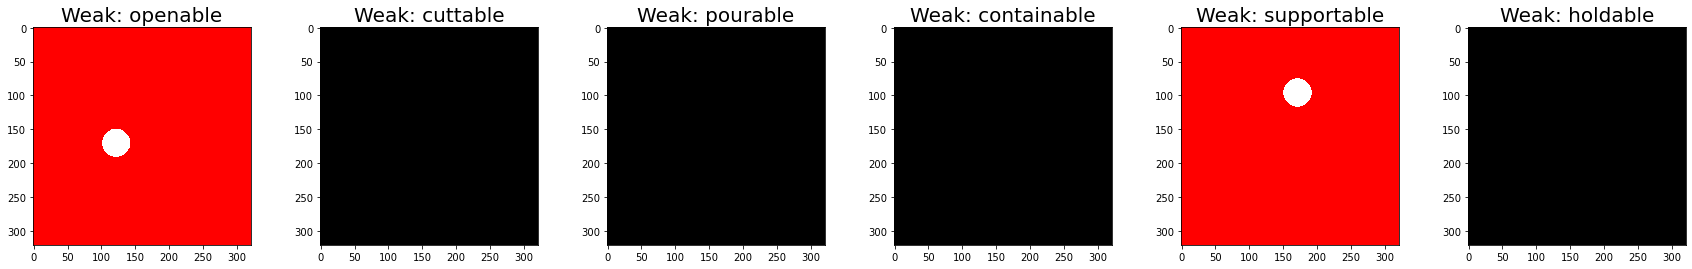

In [10]:
weak_target_path = "../dataset/cad120/object/train_affordance_weak_label/10009_1.pkl"
with open(weak_target_path, "rb") as fb:
    weak_label = pickle.load(fb)
print(weak_label.shape)
print(weak_label.dtype)
weak_label = np.split(weak_label, 6, axis=2)
weak_label = [Image.fromarray(it.squeeze(2), mode="L") for it in weak_label]
weak_label = [np.array(it) for it in weak_label]
# print(weak_label.)

target_path = "../dataset/cad120/object/affordance/labels/10009_1.pkl"

plot(weak_target=weak_label)